In [23]:
import spacy
from spacy.tokens import DocBin
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
ru_stopwords = set(stopwords.words("russian"))
en_stopwords = set(stopwords.words("english"))

ru_stopwords.add('это')
ru_stopwords.add('всё')
ru_stopwords.add('свой')
ru_stopwords.add('ещё')
ru_stopwords.add('весь')

en_stopwords.add("'s")

from string import punctuation
punct_list = [c for c in punctuation]
punct_list.append('--')
punct_list.append('...')
punct_list.append('–')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\warri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [114]:
with open("corpora/subtitles/translations/opus10_spacy_check.bin", "rb") as file:
    en_translated_bytes_data = file.read()

nlp = spacy.blank("en")
doc_bin = DocBin().from_bytes(en_translated_bytes_data)
en_translated_docs = list(doc_bin.get_docs(nlp.vocab))

In [41]:
len(en_translated_docs)

2443

In [40]:
with open("corpora/subtitles/en_subtitles_spacy_dump.bin", "rb") as file:
    en_bytes_data = file.read()

nlp = spacy.blank("en")
doc_bin = DocBin().from_bytes(en_bytes_data)
en_docs = list(doc_bin.get_docs(nlp.vocab))

Kids can get pretty much anything they want in the yard , as long as they can afford it . 

In [42]:
en_docs[820]

Kids are always gonna get into fights , right ? 

In [27]:
with open("corpora/subtitles/ru_subtitles_spacy_dump.bin", "rb") as file:
    ru_bytes_data = file.read()

nlp = spacy.blank("ru")
doc_bin = DocBin().from_bytes(ru_bytes_data)
ru_docs = list(doc_bin.get_docs(nlp.vocab))
ru_docs[5]

Да , думаю у Донни немножко есть . 

In [43]:
ru_docs[820]

Дети всегда будут драться , верно ? 

In [176]:
with open("corpora/subtitles/numerical_alignment/subtitles_inter.txt", "rt", encoding="utf-8") as file:
    aligned_inter = [[tuple(map(int, pair.split('-'))) for pair in line.strip().split()] for line in file]

with open("corpora/subtitles/numerical_alignment/subtitles_itermax.txt", "rt", encoding="utf-8") as file:
    aligned_itermax = [[tuple(map(int, pair.split('-'))) for pair in line.strip().split()] for line in file]

with open("corpora/subtitles/numerical_alignment/subtitles_mwmf.txt", "rt", encoding="utf-8") as file:
    aligned_mwmf = [[tuple(map(int, pair.split('-'))) for pair in line.strip().split()] for line in file]

with open("corpora/subtitles/translations/inter", "rt", encoding="utf-8") as file:
    t_aligned_inter = [[tuple(map(int, pair.split('-'))) for pair in line.strip().split()] for line in file]

with open("corpora/subtitles/translations/itermax", "rt", encoding="utf-8") as file:
    t_aligned_itermax = [[tuple(map(int, pair.split('-'))) for pair in line.strip().split()] for line in file]

with open("corpora/subtitles/translations/mwmf", "rt", encoding="utf-8") as file:
    t_aligned_mwmf = [[tuple(map(int, pair.split('-'))) for pair in line.strip().split()] for line in file]

In [29]:
def plot_variety_pie(variety_dict, original_word: str):
    variety_dict_items = list(variety_dict.items())
    variety_dict_items.sort(key=lambda x: -len(x[1]))
    translations = [x[0] for x in variety_dict_items]
    # translations.append("other")
    number_of_matches = [len(x[1]) for x in variety_dict_items]
    # number_of_matches.append(other_len)

    # Creating autocpt arguments
    def func(pct, allvalues):
        absolute = int(pct / 100.*np.sum(allvalues))
        return "{:.1f}%\n({:d})".format(pct, absolute)

    # Creating plot
    fig = plt.figure(figsize =(10, 7))
    plt.pie(number_of_matches, autopct = lambda pct: func(pct, number_of_matches), labels = translations)

    plt.title(original_word)
    plt.legend(bbox_to_anchor=(0.85,1.025), loc="upper left")

    # show plot
    plt.show()

In [264]:
def get_variety_dict_from_alignment(original_word: str, aligned_text: list, t_aligned_text: list):
    variety_dict = defaultdict(lambda : set())
    translation_dict = defaultdict(lambda : set())
    for i, num_sentence_pairs in tqdm(enumerate(aligned_text)):
        if len(num_sentence_pairs) == 0:
            continue
        phrase = []
        for src_idx, tgt_idx in num_sentence_pairs:
            # try:
                if ru_docs[i][src_idx].lemma_.lower() == original_word \
                    and en_docs[i][tgt_idx].text.lower() not in en_stopwords \
                        and en_docs[i][tgt_idx].text.lower() not in punct_list:
                    phrase.append(en_docs[i][tgt_idx].lemma_.lower())

            # except:
            #     print("Original:", i, src_idx, tgt_idx)
            #     continue

        if phrase:
            phrase.sort()
            phrase = ' '.join(phrase)
            variety_dict[phrase].add(i)

            translated_phrase = []
            for tsrc_idx, ttgt_idx in t_aligned_text[i]:
                # try:
                    tlemma = en_translated_docs[i][ttgt_idx].lemma_.lower()
                    if ru_docs[i][tsrc_idx].lemma_.lower() == original_word \
                        and tlemma not in en_stopwords \
                            and tlemma not in punct_list:
                        # translation_dict[tlemma].append(i)
                        translated_phrase.append(tlemma)
                # except:
                #     print("Translation:", i, tsrc_idx, ttgt_idx)
                #     continue
            
            translated_phrase.sort()
            translated_phrase = ' '.join(translated_phrase)
            translation_dict[translated_phrase].add(i)

    return variety_dict, translation_dict

In [142]:
len(t_aligned_inter)

900000

In [198]:
ru_docs[1786][0].lemma_

'хороший'

In [183]:
en_translated_docs[1786]

It's better not to get involved.

In [227]:
from simalign import SentenceAligner
myaligner = SentenceAligner(model="bert", token_type="bpe", matching_methods="mai")

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
2023-05-08 23:09:12,729 - simalign.simalign - INFO - Initialized the EmbeddingLoader with model: bert-base-multilingual-cased


In [228]:
i = 1786
ru_tokens = [token.text for token in ru_docs[i]]
translated_tokens = [token.text for token in en_translated_docs[i]]
print(f"{ru_tokens}\n{translated_tokens}\n")
src, trg = (ru_tokens, translated_tokens)
alignments = myaligner.get_word_aligns(src, trg)

['Лучше', 'ни', 'во', 'что', 'не', 'вмешиваться', '.']
['It', "'s", 'better', 'not', 'to', 'get', 'involved', '.']



In [230]:
alignments['mwmf']

[(0, 0), (0, 1), (0, 2), (3, 1), (4, 3), (5, 4), (5, 5), (5, 6), (6, 7)]

In [232]:
for i in broken:
    print(f"RU: {ru_docs[i]}\nTRANSLATED: {en_translated_docs[i]}\nALIGNED: {t_aligned_mwmf[i]}")
    print()
    for src, tgt in t_aligned_mwmf[i]:
        print(f"{ru_docs[i][src]} - {en_translated_docs[i][tgt]}")
    print("===================")

RU: Лучше ни во что не вмешиваться . 
TRANSLATED: It's better not to get involved.
ALIGNED: [(0, 0), (0, 1), (0, 2), (3, 1), (4, 3), (5, 4), (5, 5), (5, 6), (6, 7)]

Лучше - It
Лучше - 's
Лучше - better
что - 's
не - not
вмешиваться - to
вмешиваться - get
вмешиваться - involved
. - .
RU: но лучше не повторяй этого . 
TRANSLATED: But don't say it again.
ALIGNED: [(0, 0), (1, 1), (2, 2), (3, 2), (3, 3), (3, 5), (4, 4), (5, 6)]

но - But
лучше - do
не - n't
повторяй - n't
повторяй - say
повторяй - again
этого - it
. - .
RU: Все теперь хорошо , Джош . 
TRANSLATED: It's okay now, Josh.
ALIGNED: [(0, 0), (1, 3), (2, 2), (3, 4), (4, 2), (4, 5), (5, 6)]

Все - It
теперь - now
хорошо - okay
, - ,
Джош - okay
Джош - Josh
. - .
RU: Лучший столик , пожалуйста , сэр . Я здесь не работаю . 
TRANSLATED: The best table, please, sir. I don't work here.
ALIGNED: [(0, 1), (1, 0), (1, 2), (2, 3), (3, 4), (3, 10), (4, 5), (5, 6), (5, 10), (6, 7), (7, 8), (8, 12), (9, 10), (10, 9), (10, 11), (11, 13)]

Лучш

In [261]:
len(broken)

40554

In [267]:
data[0].keys()

dict_keys(['small', 'little', 'cute', 'make', 'less', 'little nice', 'party small', 'beautiful', 'young', 'nice', 'half', 'slim', 'few', 'one', 'tiny', 'baby', 'old', 'girl', 'kitty', 'pretty', 'raise', 'short', 'dirty', 'paint', 'narrator', 'small small', 'thin', 'marvellous', 'thief', 'one small', 'much', 'dark', 'kid', 'adorable little', 'silly', 'conceited', 'size', 'child', 'poor', 'horse', 'overnight', 'little soft', 'quaint', 'little little', 'protege', 'corny', 'baby little', 'boy', 'little private', 'differently', 'guy little', 'midget', 'big orphan', 'shadow', 'quick', 'anxious', 'thing tiny', 'slight slight', 'angry', 'big', 'little three', 'drink little', 'walk', 'dear little', 'little makeshift', 'nasty', 'bitty', 'inexpert little', 'child small', 'less less', 'little small', 'boy little', 'slight', 'stop', 'least', 'lazy', 'shabby', 'pretentious', "'t", 'cute little', 'green-shuttered little', 'big sign', 'stuff', "'less", 'lesser', 'little pretty', 'good', 'mine', 'small

900000it [00:04, 190637.49it/s]


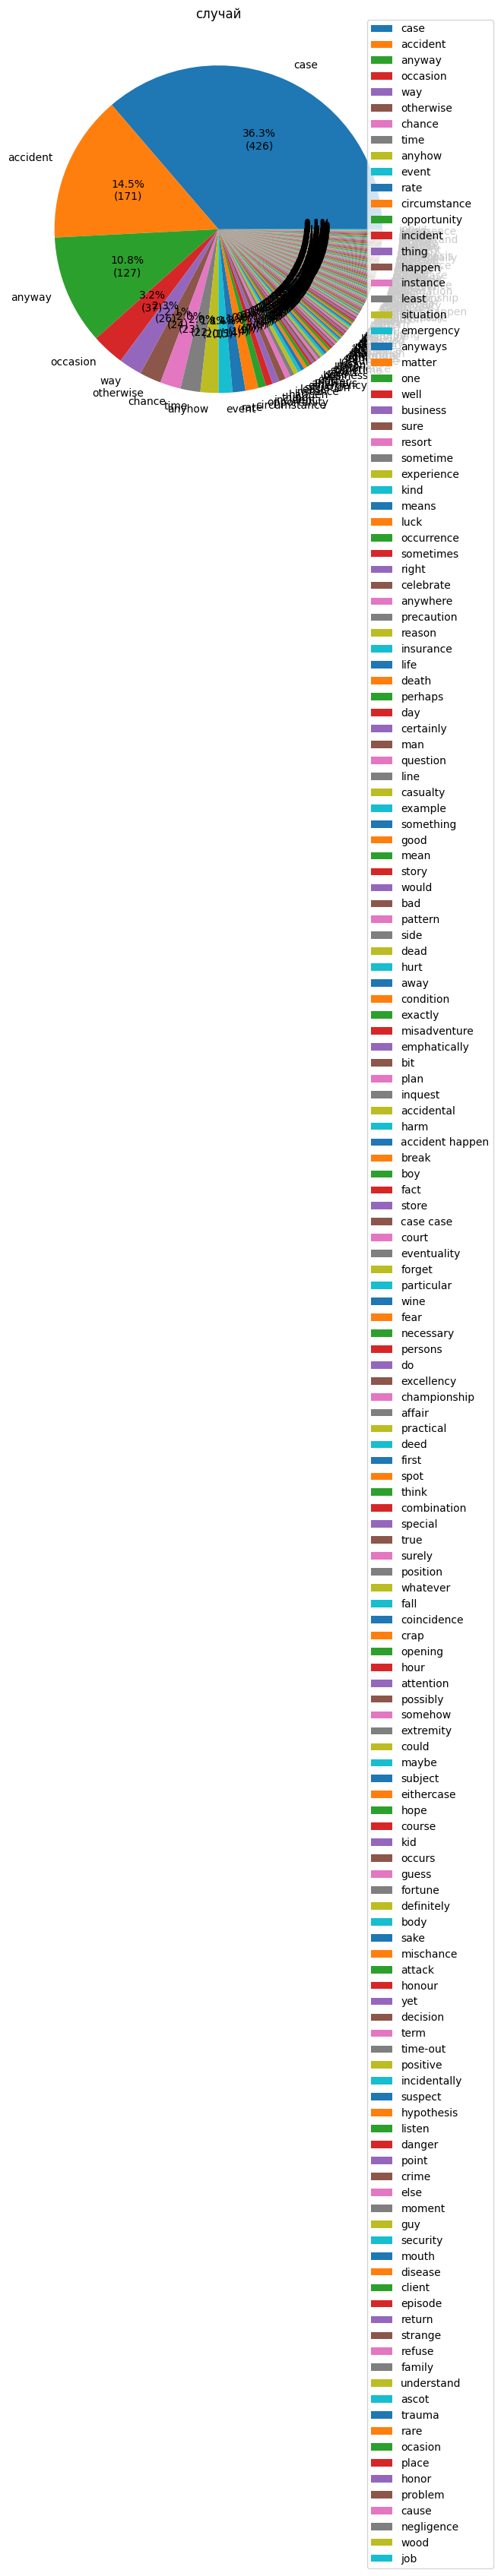

In [409]:
word = "случай"
data = get_variety_dict_from_alignment(word, aligned_inter, t_aligned_inter)
plot_variety_pie(data[0], word)

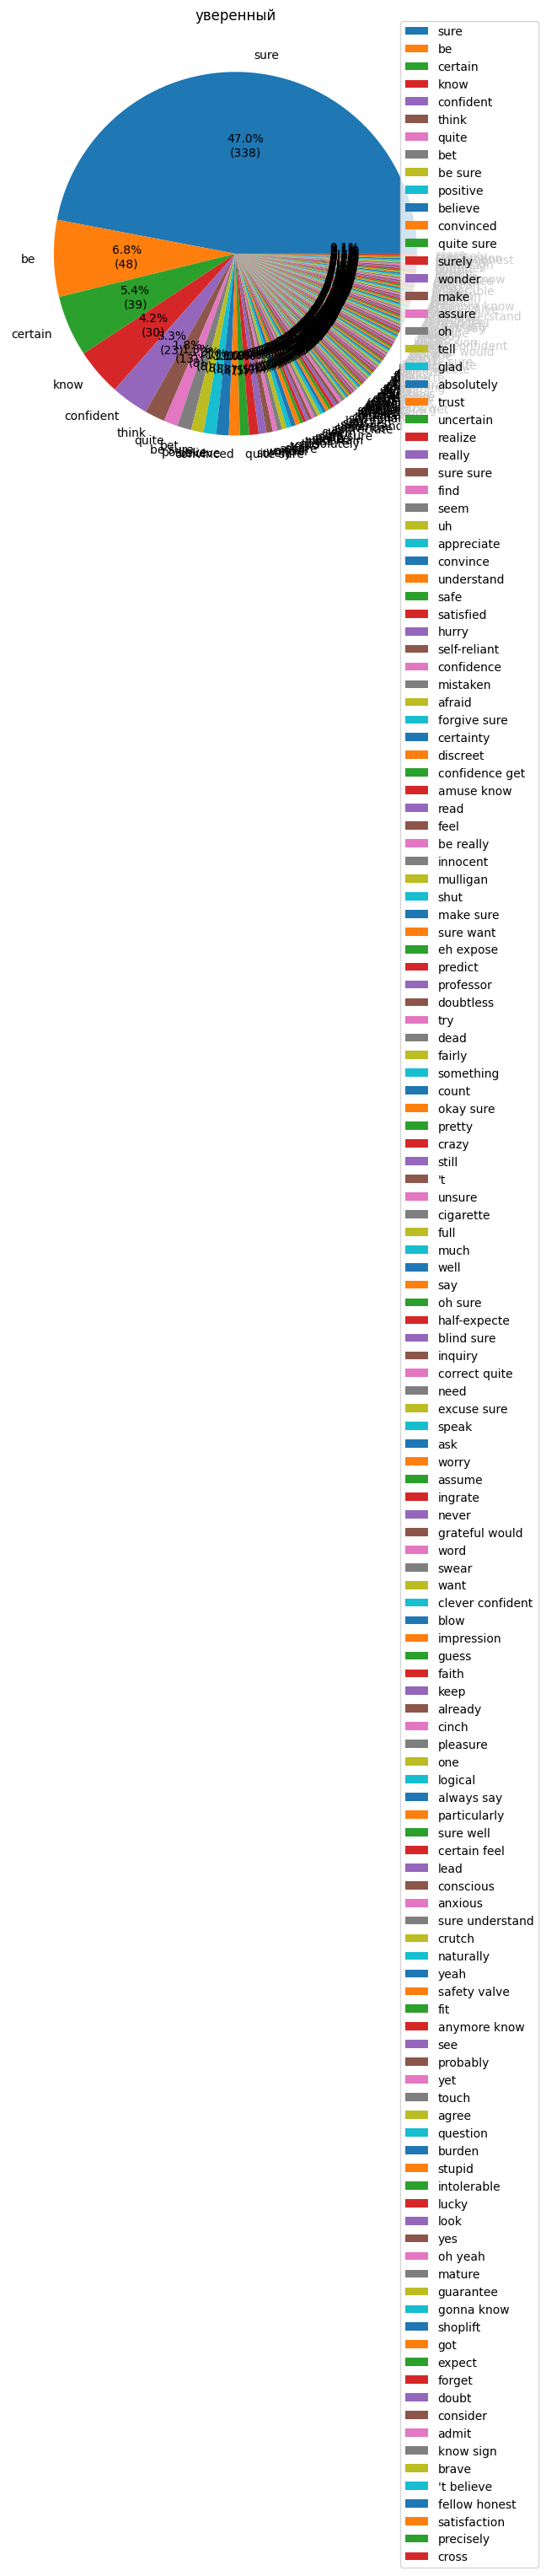

In [366]:
plot_variety_pie(data[0], word)#+ " (nmt)") #

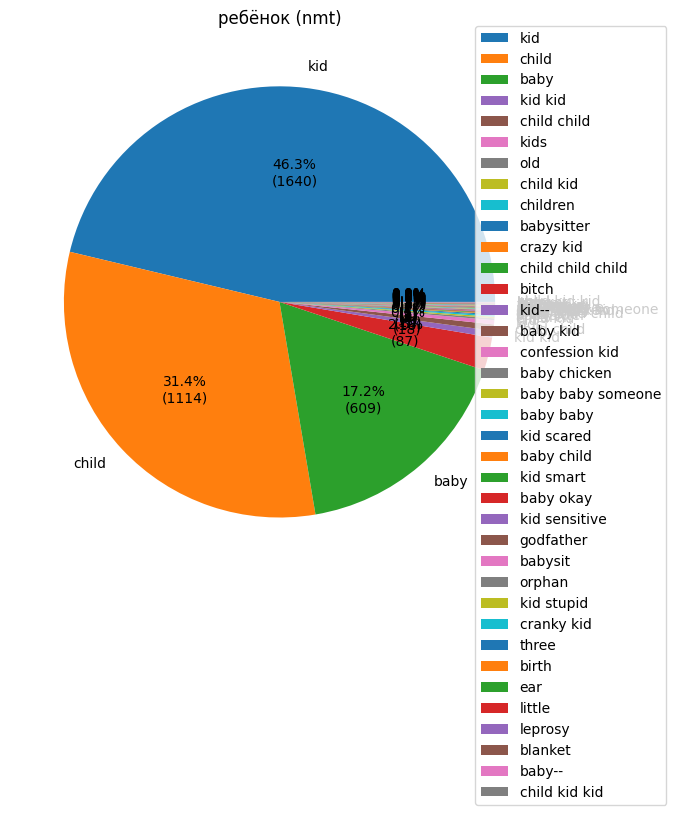

In [319]:
plot_variety_pie(data[1], word + " (nmt)") #

In [308]:
len(data[1][""])

346

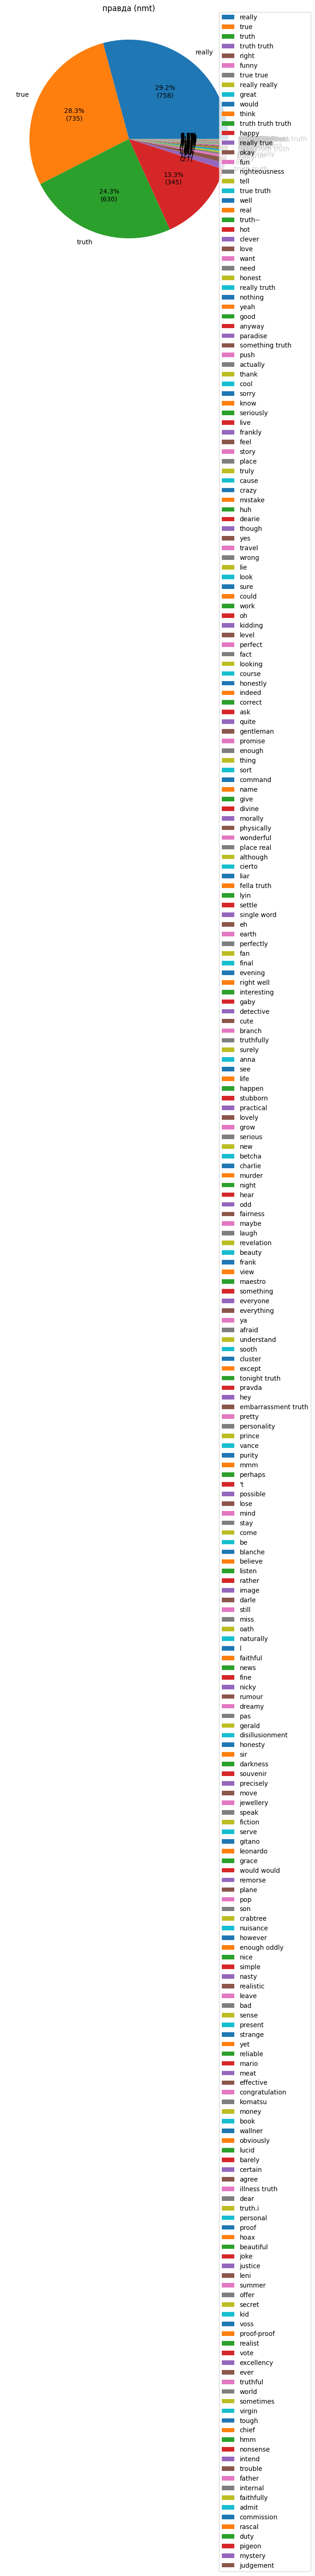

In [307]:
plot_variety_pie(data[1], f"{word} (nmt)")

In [121]:
def compare_dicts(variety_dict: defaultdict, translated_dict: defaultdict):
    same_set = set()
    different_set = set()
    for key, value in variety_dict.items():
        same_set = same_set.union(translated_dict[key].intersection(value))
        different_set = different_set.union(translated_dict[key].symmetric_difference(value))
    for key, value in translated_dict.items():
        same_set = same_set.union(variety_dict[key].intersection(value))
        different_set = different_set.union(variety_dict[key].symmetric_difference(value))

    print(f"same {(len(same_set)/(len(same_set) + len(different_set)))*100}%")
    return same_set, different_set

same 60.23076923076923%


In [88]:
with open("subtitles_raw/en_raw_0-900.txt", "rt", encoding="utf-8") as f:
    en_corpus_raw = [line.strip() for line in f]

with open("subtitles_raw/ru_raw_0-900.txt", "rt", encoding="utf-8") as f:
    ru_corpus_raw = [line.strip() for line in f]

with open("corpora/subtitles/translations/opus10_whole.txt", "rt", encoding="utf-8") as f:
    translated_corpus_raw = [line.strip() for line in f]

In [90]:
ru_corpus_raw[36868]

'Он мой лучший друг .'

In [321]:
same_set, different_set = compare_dicts(data[0], data[1])

same 43.839864674372706%


In [322]:
with open("./tmpfile.txt", "wt", encoding="utf-8") as file:
    for i in different_set:
        file.write(f"SENTENCE NUMBER: {i}\n\n")
        file.write(f"RU: {ru_corpus_raw[i]}\n\n")
        file.write(f"EN: {en_corpus_raw[i]}\n\n")
        file.write(f"TRANSLATED: {translated_corpus_raw[i]}\n\n")
        file.write("=========================\n\n")

In [325]:
def compare_dicts_one_word(variety_dict: defaultdict, translated_dict: defaultdict, word: str):
    same_set = set()
    different_set = set()
    for key, value in variety_dict.items():
        if key == word:
            same_set = same_set.union(translated_dict[key].intersection(value))
            different_set = different_set.union(translated_dict[key].symmetric_difference(value))
    for key, value in translated_dict.items():
        if key == word:
            same_set = same_set.union(variety_dict[key].intersection(value))
            different_set = different_set.union(variety_dict[key].symmetric_difference(value))

    print(f"same {(len(same_set)/(len(same_set) + len(different_set)))*100}%")
    return same_set, different_set

In [326]:
s_set, d_set = compare_dicts_one_word(data[0], data[1], "baby")

same 34.62033462033462%


In [328]:
with open("./tmpfile.txt", "wt", encoding="utf-8") as file:
    for i in d_set:
        file.write(f"SENTENCE NUMBER: {i}\n\n")
        file.write(f"RU: {ru_corpus_raw[i]}\n\n")
        file.write(f"EN: {en_corpus_raw[i]}\n\n")
        file.write(f"TRANSLATED: {translated_corpus_raw[i]}\n\n")
        file.write("=========================\n\n")